In [50]:
import os
import numpy as np
import re
import pickle
import sys
import matplotlib.pyplot as plt
import pandas as pd
pd.set_option('display.float_format', lambda x: '%.6f' % x)
import seaborn as sns
import scipy.stats as stats
import datetime
import geopandas as gpd
from shapely.geometry import Point
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib.colors as mcolors
from statsmodels.graphics.mosaicplot import mosaic
import json

sys.path.insert(1, '../')
from SeasonalPlot_Functions import *
from LoadingPlot_Functions import *

In [51]:
# Function to plot the change in theta_mean for a given duration
def plot_change_variable_for_duration(ax, variable, duration, df_changes, tbo_vals, cmap = 'viridis'):
    # Filter the data for the given duration
    change_R_data = df_changes[df_changes['sampling_duration'] == float(duration)][['gauge_num', variable]]
    
    # Get longitude and latitude from gauge locations
    gauge_locs = change_R_data['gauge_num'].copy()

    # Now index into gauge_locations with the copied values
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for theta change
    scatter = ax.scatter(lon, lat, c=change_R_data[variable], cmap=cmap, edgecolor=None, s= 8, alpha=0.9)
    ax.set_title(f'{variable} (Duration: {duration} hours)')
    #ax.set_xlabel('Longitude')
    #ax.set_ylabel('Latitude')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # Create a color bar that is scaled to the size of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Control the width and padding of the colorbar
    plt.colorbar(scatter, cax=cax, label=f'{variable}')   
    
def plot_values_on_map(ax, data, title, tbo_vals, value_column, vmin, vmax, cmap='viridis'):
    
    gauge_locs = data['gauge_num'].copy()

    # Now index into gauge_locations with the copied values
    lon = tbo_vals.loc[gauge_locs, 'Lon']
    lat = tbo_vals.loc[gauge_locs, 'Lat']
    
    # Plot the background outline of Great Britain
    gb_outline.plot(ax=ax, color='lightgrey', edgecolor='black', linewidth=1)
    
    # Scatter plot for the specified value column
    scatter = ax.scatter(lon, lat, c=data[value_column], cmap=cmap, edgecolor=None, alpha=0.9, s=6, 
                         vmin =vmin, vmax=vmax)
    ax.set_title(title)
    #ax.set_xlabel('Longitude')
    #ax.set_ylabel('Latitude')
    ax.set_xticklabels([]); ax.set_yticklabels([])
    
    # Create a color bar that is scaled to the size of the plot
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="5%", pad=0.05)  # Control the width and padding of the colorbar
    plt.colorbar(scatter, cax=cax)
    
    
def plot_present_future_changes(axes, row, input_df_changes, variable, variable_to_plot_present, variable_to_plot_future, 
                                variable_to_plot_diff, cmap, cmap_diff, low_lim, high_lim):
    # Present Climate 
    present_data = input_df_changes[['gauge_num', variable_to_plot_present]].copy()
    present_data['Climate'] = 'present'  # Add a Climate column for clarity
    # Future Climate
    future_data = input_df_changes[['gauge_num', variable_to_plot_future]].copy()
    future_data['Climate'] = 'future'  # Add a Climate column for clarity
    # Change 
    change_data = input_df_changes[['gauge_num', variable_to_plot_diff]].copy()
    change_data['Climate'] = 'change'  # Add a Climate column for clarity

    global_min = min(present_data[variable_to_plot_present].min(),
                     future_data[variable_to_plot_future].min())
    global_max = max(present_data[variable_to_plot_present].max(),
                     future_data[variable_to_plot_future].max())
    
    ### Plot
    if len(axes.shape) == 1:
        # Case with just one row of axes
        plot_values_on_map(axes[0], present_data, f'Present Climate - {variable} Values', tbo_vals,
                           variable_to_plot_present, low_lim, high_lim, cmap)
        plot_values_on_map(axes[1], future_data, f'Future Climate - {variable} Values', tbo_vals, 
                           variable_to_plot_future, low_lim, high_lim, cmap)
        plot_values_on_map(axes[2], change_data, f'Change in {variable} Values', tbo_vals, 
                           variable_to_plot_diff, vmin=-2, vmax=2, cmap=cmap_diff)
    else:
        # Case with multiple rows of axes
        plot_values_on_map(axes[row, 0], present_data, f'Present Climate - {variable} Values', tbo_vals,
                           variable_to_plot_present, low_lim, high_lim, cmap)
        plot_values_on_map(axes[row, 1], future_data, f'Future Climate - {variable} Values', tbo_vals, 
                           variable_to_plot_future, low_lim, high_lim, cmap)
        plot_values_on_map(axes[row, 2], change_data, f'Change in {variable} Values', tbo_vals, 
                           variable_to_plot_diff, vmin=-2, vmax=2, cmap=cmap_diff)
        
    # Adjust layout
    plt.tight_layout()        

In [52]:
home_dir = '/nfs/a319/gy17m2a/PhD/'
home_dir2 = '/nfs/a161/gy17m2a/PhD/'

In [53]:
gdf = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))

# Filter for Great Britain
gb_outline = gdf[(gdf.name == "United Kingdom")]

In [54]:
quintile_mapping = {1: 'F2', 2: 'F1', 3: 'C', 4: 'B1', 5: 'B2'}
quintile_mapping_thirds = {1: 'F', 2: 'C', 3: 'B'}
quintile_cats = ['F2','F1', 'C', 'B1', 'B2']
color_mapping = {'F2': (0.0, 0.0, 1.0, 0.6),   'F1': (0.0, 0.6902, 1.0, 0.6),
    'C': (0.5, 0.5, 0.5, 0.6), 'B1': (0.8039, 0.0, 0.0, 0.6),'B2': (0.5451, 0.0, 0.0, 0.6)} 

In [55]:
tbo_vals = pd.read_csv(home_dir + 'datadir/RainGauge/interarrival_thresholds_CDD_noMissing.txt')
tbo_vals = tbo_vals[tbo_vals['Lon']!=-999.0]
tbo_vals['gauge_num'] = tbo_vals.index

## Read in data

df_long contains all events, including a column listing all the durations which it is an AMAX for

In [56]:
df_long=pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics.csv")
df_long['dur_for_which_this_is_amax'] = df_long['dur_for_which_this_is_amax'].apply(json.loads)
# df_long = df_long[df_long['duration'] >=1.5]
present=df_long[df_long['Climate']=='Present']
future=df_long[df_long['Climate']=='Future']

nimrod = pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/NIMROD_30mins/all_events_characteristics.csv")
nimrod = nimrod[nimrod['duration'] >=1.5]

df_changes contain values for changes between present and future for various characteristics (theta, R, D50 etc)

In [57]:
df_changes_all= pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_allevents.csv")
df_changes_all_season=pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_allevents.csv")
df_changes_all_summer = df_changes_all_season[df_changes_all_season['season']=='Summer']
df_changes_all_autumn = df_changes_all_season[df_changes_all_season['season']=='Autumn']

df_changes_byduration=pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_changes_bydur.csv")
df_changes_byduration_season =pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/grouped_by_gauge_season_changes_bydur.csv")
df_changes_byduration_summer =df_changes_byduration_season[df_changes_byduration_season['season']=="Summer"]
df_changes_byduration_autumn =df_changes_byduration_season[df_changes_byduration_season['season']=="Autumn"]

In [58]:
df_long_withshort=pd.read_csv(home_dir + f"ProcessedData/AMAX_Events/UKCP18_30mins/all_events_characteristics_shortdurationskept.csv")

# What's going on with D50??

In [59]:
# vals, counts = np.unique(h24['duration'], return_counts=True)
# test=pd.DataFrame({'vals':vals, 'counts':counts})
# test.sort_values(by='counts', ascending=False)[0:10]

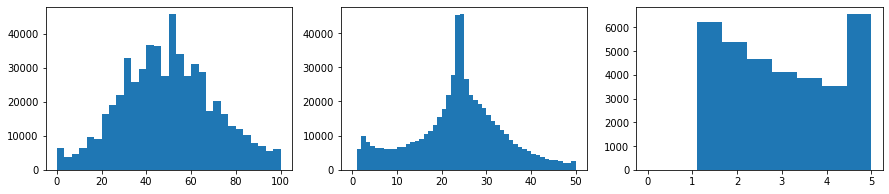

In [60]:
fig, axs = plt.subplots(ncols=3,figsize=(15,3))

axs[0].hist(h24['D50'], bins =30);
# axs[1].hist(df_long['duration'], bins =50);

bins = np.linspace(0, 50, 51);
axs[1].hist(h24['duration'], bins=bins);

bins = np.linspace(0, 5, 10);
axs[2].hist(h24['duration'], bins=bins);

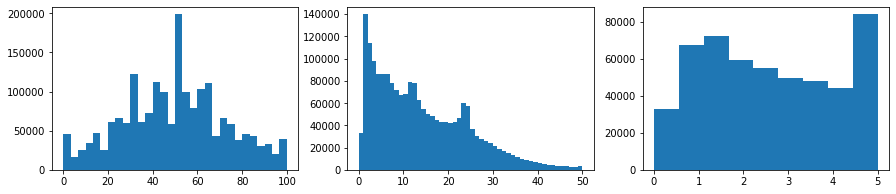

In [61]:
fig, axs = plt.subplots(ncols=3,figsize=(15,3))

axs[0].hist(df_long['D50'], bins =30);
# axs[1].hist(df_long['duration'], bins =50);

bins = np.linspace(0, 50, 51);
axs[1].hist(df_long_withshort['duration'], bins=bins);

bins = np.linspace(0, 5, 10);
axs[2].hist(df_long_withshort['duration'], bins=bins);

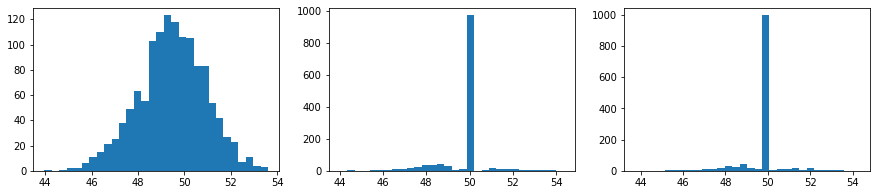

In [62]:
fig, axs = plt.subplots(ncols=3,figsize=(15,3))

axs[0].hist(df_changes_all['D50_mean_present'], bins =30);
axs[1].hist(df_changes_all['D50_median_present'], bins =30);
axs[2].hist(df_changes_all['D50_median_future'], bins =30);

# Plot Roberto loading categories

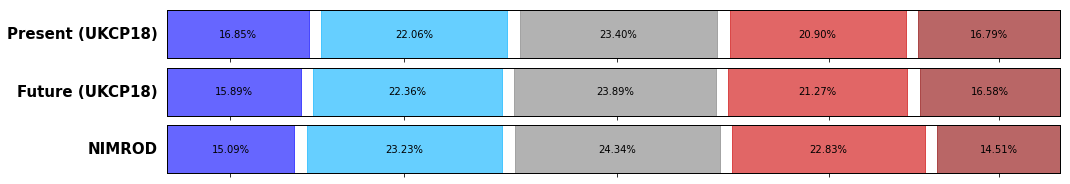

In [63]:
my_dict = {'Present (UKCP18)' :present, 'Future (UKCP18)':future,
           'NIMROD':nimrod}
short_ids = ['Present (UKCP18)', 'Future (UKCP18)', 'NIMROD']

# Create the subplots
fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 3), sharex=True)

# Loop over each id and create the plots
for i, id in enumerate(short_ids):
    create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'Loading_profile_molly', 
        quintile_cats, color_mapping,  short_ids[i])

# Add the overall title
# fig.suptitle('All events', fontweight="bold", fontsize=20);

In [64]:
# for gauge_num in range(1000,1020):
#     present_thisgauge=present[present['gauge_num']==gauge_num]
#     future_thisgauge=future[future['gauge_num']==gauge_num]
#     short_ids = ['Present (UKCP18)', 'Future (UKCP18)']
#     my_dict = {'Present (UKCP18)' :present_thisgauge, 'Future (UKCP18)':future_thisgauge}

#     # Create the subplots
#     fig, axs = plt.subplots(nrows=len(short_ids), figsize=(16, 2), sharex=True)

#     # Loop over each id and create the plots
#     for i, id in enumerate(short_ids):
#         create_single_variable_mosaic_plot_pctlabels(axs[i], my_dict[id], 'Loading_profile_molly', 
#             quintile_cats, color_mapping,  short_ids[i])

# D50 analysis


## Present + future + change (all durations lumped)  

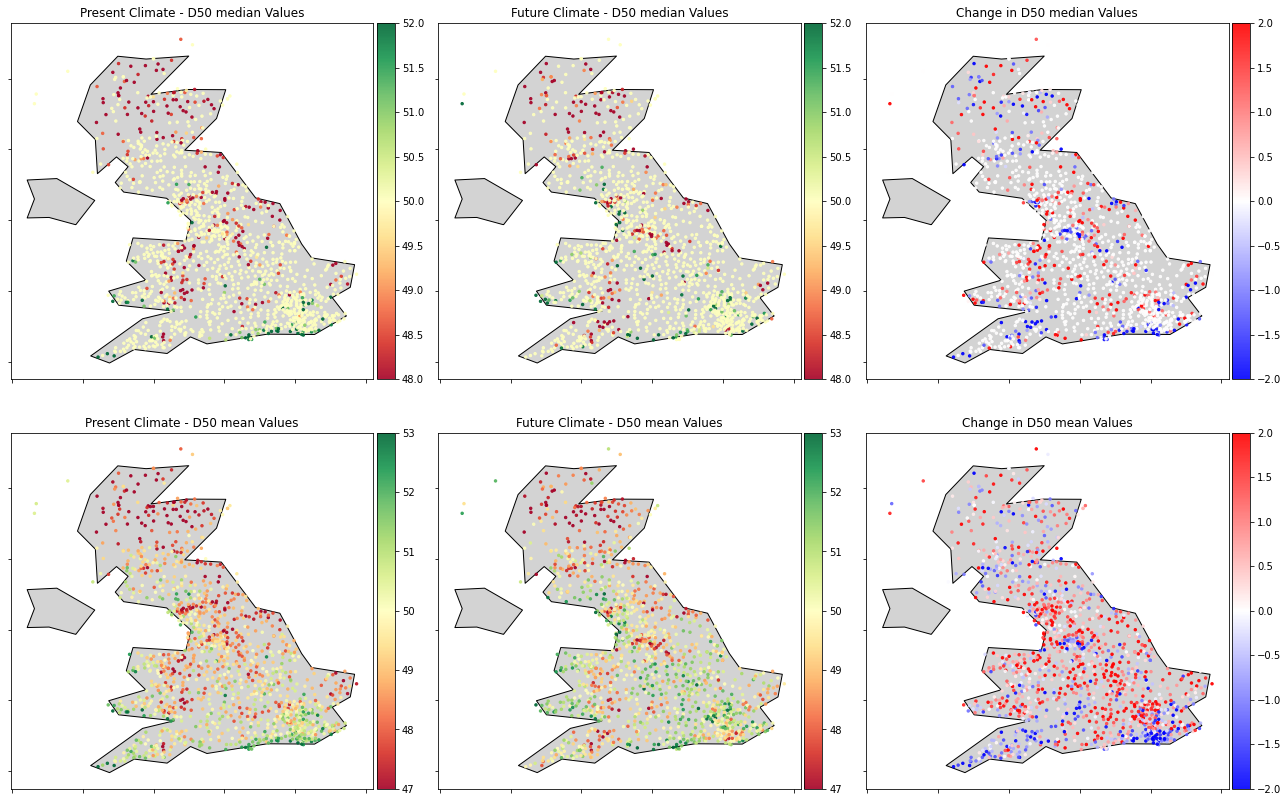

In [65]:
# Create a figure and axes for the six subplots
fig, axes = plt.subplots(2, 3, figsize=(18, 12))
plot_present_future_changes(axes, 0, df_changes_all,'D50 median', 'D50_median_present', 'D50_median_future',
                           'D50_median_diff', 'RdYlGn', 'bwr', 48,52)
plot_present_future_changes(axes, 1, df_changes_all,'D50 mean', 'D50_mean_present', 'D50_mean_future',
                           'D50_mean_diff', 'RdYlGn', 'bwr', 47, 53)

### Try for just one duration

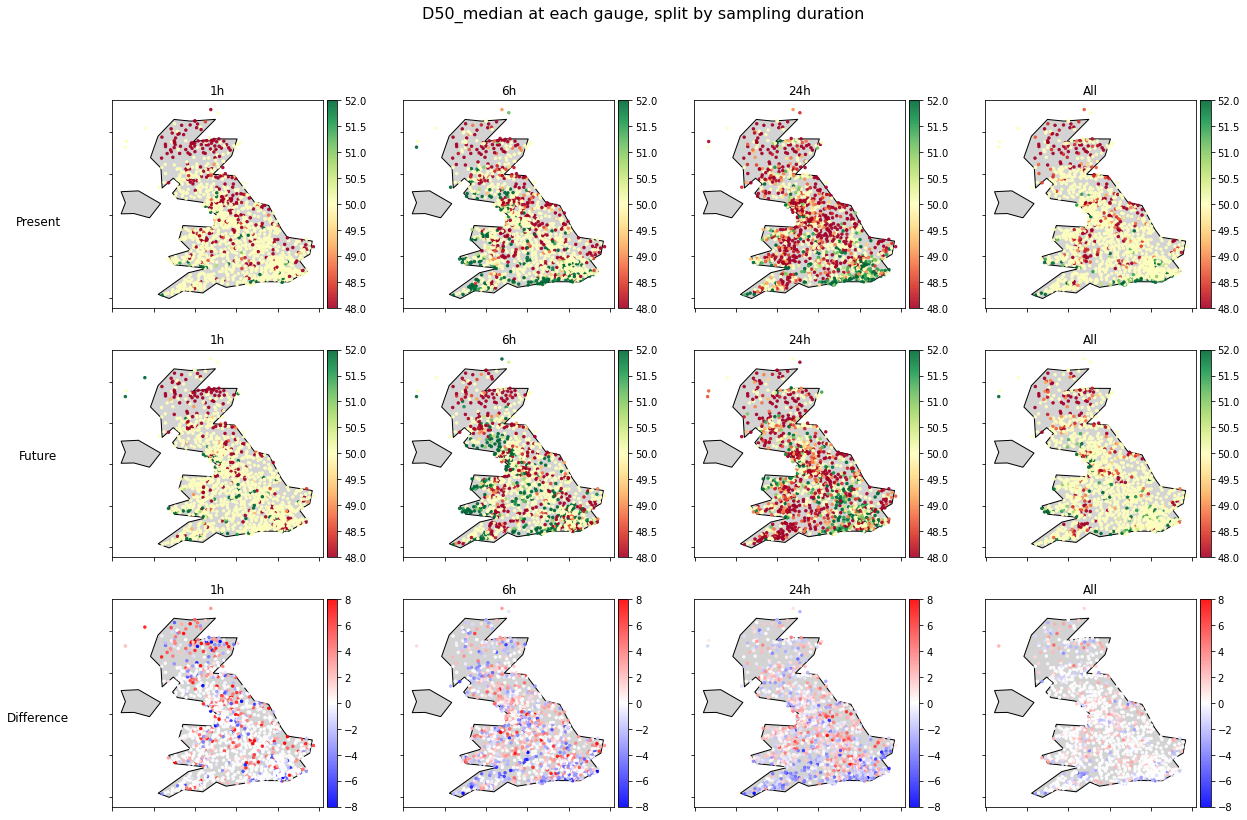

In [78]:
fig, axes = plt.subplots(3, 4, figsize=(20, 13))

cmap = 'RdYlGn'

#################################################
# Present
#################################################
variable = "D50_median"
variable_to_plot = f'{variable}_present'
low_lim=48
high_lim=52

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[0,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[0,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[0,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap=cmap)    


### Plot 'All' values
present_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
present_data['Climate'] = 'present'  # Add a Climate column for clarity   

plot_values_on_map(axes[0,3], present_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)


#################################################
# Future
#################################################   
variable_to_plot = f'{variable}_future'
low_lim=48
high_lim=52

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[1,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap=cmap)    


### Plot 'All' values
future_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
future_data['Climate'] = 'future'  # Add a Climate column for clarity   

plot_values_on_map(axes[1,3], future_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap=cmap)



#################################################
# Difference
#################################################
variable_to_plot = f'{variable}_diff'
low_lim=-8
high_lim=+8
cmap = 'bwr'

present_data = df_changes_all[['gauge_num', variable_to_plot]].copy()
present_data['Climate'] = 'present'  # Add a Climate column for clarity    

# For each duration
this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(1)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,0], this_duration, '1h', tbo_vals,
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(6)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,1], this_duration, '6h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap)

this_duration = df_changes_byduration[df_changes_byduration['sampling_duration'] == float(24)][['gauge_num', variable_to_plot]]
plot_values_on_map(axes[2,2], this_duration, '24h', tbo_vals, 
                   variable_to_plot, low_lim, high_lim, cmap=cmap)    

# All
plot_values_on_map(axes[2,3], present_data, 'All', tbo_vals, 
                   variable_to_plot, vmin=low_lim, vmax=high_lim, cmap='bwr')

fig.text(0.08, 0.750, 'Present', va='center', ha='center', fontsize=12, rotation='horizontal');
fig.text(0.08, 0.5, 'Future', va='center', ha='center', fontsize=12, rotation='horizontal');
fig.text(0.08, 0.22, 'Difference', va='center', ha='center', fontsize=12, rotation='horizontal');

plt.suptitle(f'{variable} at each gauge, split by sampling duration', fontsize=16);

## Comparing methods

In [79]:
df_long = df_long.sort_values('Loading_profile_molly')
df_long = df_long.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

present = present.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)
future = future.sort_values('Loading_profile_molly', key=lambda s: s.apply(['F2', 'F1', 'C', 'B1', 'B2'].index), ignore_index=True)

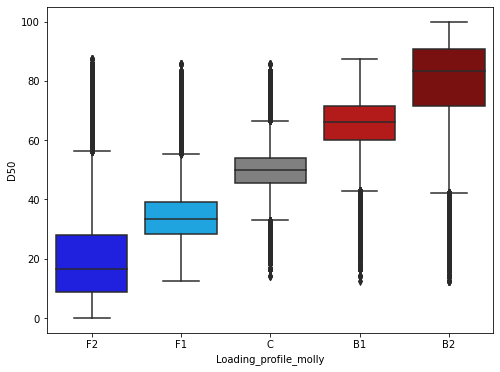

In [80]:
fig, axs = plt.subplots(figsize=(8,6))
plot_boxplot(df_long[['Loading_profile_molly', 'D50']], axs, color_mapping)
plt.show()

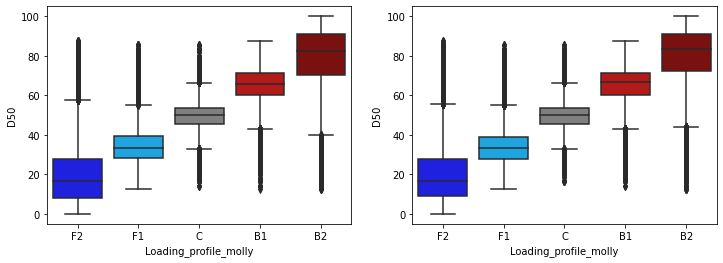

In [22]:
fig, axs = plt.subplots(ncols=2, figsize=(12,4))
plot_boxplot(present[['Loading_profile_molly', 'D50']], axs[0], color_mapping)
plot_boxplot(future[['Loading_profile_molly', 'D50']], axs[1], color_mapping)
plt.show()

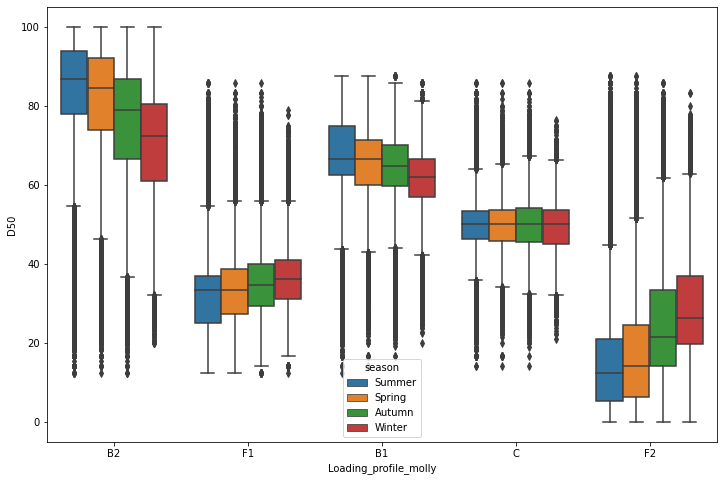

In [48]:
fig, axs = plt.subplots(figsize=(12,8))
plot_boxplot_by_season(df_long[['Loading_profile_molly', 'D50', 'season']], axs)
plt.show()

# D50 against Day of Year

In [41]:
h1 = df_long[df_long['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(1) in x or x == str(1))]
h6 = df_long[df_long['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(6) in x or x == str(6))]
h24 = df_long[df_long['dur_for_which_this_is_amax'].apply(
    lambda x: isinstance(x, list) and str(24) in x or x == str(24))]

In [88]:
# # Create a scatter plot with colors based on density
# fig, axs = plt.subplots(ncols=2, figsize=(15,8))

# test = h1[['D', 'D50', 'Climate']]
# present_h1 =test[test['Climate']=='Present'][['D', 'D50']]
# future_h1 =test[test['Climate']=='Future'][['D', 'D50']]

# # Calculate point density using Gaussian KDE
# kde_present = stats.gaussian_kde(present_h24.T)  # Transpose to have dimensions (2, n_points)
# kde_future = stats.gaussian_kde(future_h24.T)  # Transpose to have dimensions (2, n_points)

# # Calculate density for each point
# density_present = kde_present(present_h24.T)  # Evaluate the KDE at the original data points
# density_future = kde_future(future_h24.T)  # Evaluate the KDE at the original data points

# scatter_pres = axs[0].scatter(present_h24['D'], present_h24['D50'], c=density_present, cmap='viridis', edgecolor=None)
# scatter_fut = axs[1].scatter(future_h24['D'], future_h24['D50'], c=density_future, cmap='viridis', edgecolor=None)

# axs[0].set_xlabel('Day of Year')
# axs[1].set_xlabel('Day of Year')

# axs[0].set_ylabel('D50')
# axs[1].set_ylabel('D50')

In [ ]:
test = h24[['D', 'D50']]

# Calculate point density using Gaussian KDE
kde = stats.gaussian_kde(test.T)  # Transpose to have dimensions (2, n_points)

# Calculate density for each point
density = kde(test.T)  # Evaluate the KDE at the original data points

# Create a scatter plot with colors based on density
fig, ax = plt.subplots()
scatter = ax.scatter(test['D'], test['D50'], c=density, cmap='viridis', edgecolor=None)

In [ ]:
test = h6[['D', 'D50']]

# Calculate point density using Gaussian KDE
kde = stats.gaussian_kde(test.T)  # Transpose to have dimensions (2, n_points)

# Calculate density for each point
density = kde(test.T)  # Evaluate the KDE at the original data points

# Create a scatter plot with colors based on density
fig, ax = plt.subplots()
scatter = ax.scatter(test['D'], test['D50'], c=density, cmap='viridis', edgecolor=None)

In [ ]:
test = h1[['D', 'D50']]

# Calculate point density using Gaussian KDE
kde = stats.gaussian_kde(test.T)  # Transpose to have dimensions (2, n_points)

# Calculate density for each point
density = kde(test.T)  # Evaluate the KDE at the original data points

# Create a scatter plot with colors based on density
fig, ax = plt.subplots()
scatter = ax.scatter(test['D'], test['D50'], c=density, cmap='viridis', edgecolor=None)

In [ ]:
# em = df_long[df_long['D50']==100]['em'].iloc[1]
# gauge_num = df_long[df_long['D50']==100]['gauge_num'].iloc[1]
# time_period = df_long[df_long['D50']==100]['Climate'].iloc[1]
# filename =df_long[df_long['D50']==100]['filename'].iloc[1]

# indy_events_fp = home_dir2 + f"ProcessedData/IndependentEvents/UKCP18_30mins/{time_period}/{em}/{gauge_num}/WholeYear/{filename}"
# d50_100 = pd.read_csv(indy_events_fp)
# d50_100

In [87]:
# df_changes_by_season = df_changes_autumn

# # Create a figure and axes for the six subplots
# fig, axes = plt.subplots(2, 3, figsize=(18, 12))

# # Present Climate 
# present_medianD50_data = df_changes_by_season[['gauge_num', 'D50_median_present']].copy()
# present_medianD50_data['Climate'] = 'present'  # Add a Climate column for clarity
# # Future Climate
# future_medianD50_data = df_changes_by_season[['gauge_num', 'D50_median_future']].copy()
# future_medianD50_data['Climate'] = 'future'  # Add a Climate column for clarity

# global_min = min(present_medianD50_data['D50_median_present'].min(),
#     future_medianD50_data['D50_median_future'].min())

# global_max = max(present_medianD50_data['D50_median_present'].max(),
#     future_medianD50_data['D50_median_future'].max())


# plot_values_on_map(axes[0, 0], present_medianD50_data, 'Present Climate - D50 Median Values', tbo_vals,
#                    'D50_median_present', 40, 70)
# plot_values_on_map(axes[0, 1], future_medianD50_data, 'Future Climate - D50 Median Values', tbo_vals, 
#                     'D50_median_future', 40, 70)

# # # Change 
# change_medianD50_data = df_changes_by_season[['gauge_num', 'D50_median_diff']].copy()
# change_medianD50_data['Climate'] = 'change'  # Add a Climate column for clarity
# plot_values_on_map(axes[0, 2], change_medianD50_data, 'Change in D50 Median Values', tbo_vals, 'D50_median_diff', 
#                    vmin=-30, vmax=20, cmap = 'RdYlGn')


# present_meanD50_data = df_changes_by_season[['gauge_num', 'D50_mean_present']].copy()
# present_meanD50_data['Climate'] = 'present'  # Add a Climate column for clarity
# future_meanD50_data = df_changes_by_season[['gauge_num', 'D50_mean_future']].copy()
# future_meanD50_data['Climate'] = 'present'  # Add a Climate column for clarity

# global_min = min(present_meanD50_data['D50_mean_present'].min(),
#     future_meanD50_data['D50_mean_future'].min())

# global_max = max(present_meanD50_data['D50_mean_present'].max(),
#     future_meanD50_data['D50_mean_future'].max())


# plot_values_on_map(axes[1, 0], present_meanD50_data, 'Present Climate - D50 Mean Values', tbo_vals, 
#                    'D50_mean_present', global_min, global_max)
# plot_values_on_map(axes[1, 1], future_meanD50_data, 'Future Climate - D50 Mean Values', tbo_vals, 
#                     'D50_mean_future', global_min, global_max)

# # # Change 
# change_meanD50_data = df_changes_by_season[['gauge_num', 'D50_mean_diff']].copy()
# change_meanD50_data['Climate'] = 'change'  # Add a Climate column for clarity
# plot_values_on_map(axes[1, 2], change_meanD50_data, 'Change in D50 Mean Values', tbo_vals, 'D50_mean_diff', 
#                    vmin=None, vmax=None, cmap = 'RdYlGn')

# # Adjust layout
# plt.tight_layout()


In [14]:
# # Create a 10x2 subplot (10 rows, 2 columns)
# fig, axs = plt.subplots(10, 2, figsize=(15, 25), sharex='col')
# fig.subplots_adjust(hspace=0.7, wspace=0.3)  # Adjust space between plots

# # Loop through gauge numbers from 1 to 10
# for i, gauge_num in enumerate(range(1, 11)):
    
#     # Filter data for the specific gauge number in 'present' dataset
#     one_gauge_present = present[present['gauge_num'] == gauge_num]
    
#     # Filter data for the specific gauge number in 'future' dataset
#     one_gauge_future = future[future['gauge_num'] == gauge_num]
    
#     # First column: Plot using the 'present' dataset
#     ax_present = axs[i, 0]  # Access the correct subplot
#     if not one_gauge_present.empty:
#         one_gauge_present = one_gauge_present[['D', 'D50']]
        
#         # Calculate point density using Gaussian KDE
#         kde_present = stats.gaussian_kde(one_gauge_present.T)
        
#         # Calculate density for each point
#         density_present = kde_present(one_gauge_present.T)
        
#         # Create a scatter plot for 'present' data with density-based coloring
#         scatter_present = ax_present.scatter(one_gauge_present['D'], one_gauge_present['D50'], c=density_present, cmap='viridis', edgecolor=None)
    
#     # Set title and labels for the 'present' plot
#     ax_present.set_title(f'Gauge {gauge_num} - Present')
#     ax_present.set_xlabel('Day of Year (D)')
#     ax_present.set_ylabel('D50')

#     # Second column: Plot using the 'future' dataset
#     ax_future = axs[i, 1]  # Access the correct subplot
#     if not one_gauge_future.empty:
#         one_gauge_future = one_gauge_future[['D', 'D50']]
        
#         # Calculate point density using Gaussian KDE
#         kde_future = stats.gaussian_kde(one_gauge_future.T)
        
#         # Calculate density for each point
#         density_future = kde_future(one_gauge_future.T)
        
#         # Create a scatter plot for 'future' data with density-based coloring
#         scatter_future = ax_future.scatter(one_gauge_future['D'], one_gauge_future['D50'], c=density_future, cmap='viridis', edgecolor=None)

#     # Set title and labels for the 'future' plot
#     ax_future.set_title(f'Gauge {gauge_num} - Future')
#     ax_future.set_xlabel('Day of Year (D)')
#     ax_future.set_ylabel('D50')

# # Add a colorbar for the last plot (adjust as needed)
# # cbar = fig.colorbar(scatter_future, ax=axs, orientation='vertical', fraction=0.02, pad=0.02)
# # cbar.set_label('Density')

# # Display the plot
# plt.show()


In [15]:
# # Create a 5x5 subplot
# fig, axs = plt.subplots(5, 5, figsize=(15, 15))
# fig.subplots_adjust(hspace=0.4, wspace=0.4)  # Adjust space between plots

# # Loop through gauge numbers from 1 to 25 (row and column indices)
# for gauge_num, ax in enumerate(axs.flat, start=1):
    
#     # Filter data for the specific gauge number
#     one_gauge = present[present['gauge_num'] == gauge_num]
    
#     # Check if there's any data for this gauge number
#     if not one_gauge.empty:
#         one_gauge = one_gauge[['D', 'D50']]
        
#         # Calculate point density using Gaussian KDE
#         kde = stats.gaussian_kde(one_gauge.T)  # Transpose to have dimensions (2, n_points)
        
#         # Calculate density for each point
#         density = kde(one_gauge.T)  # Evaluate the KDE at the original data points
        
#         # Create a scatter plot with colors based on density
#         scatter = ax.scatter(one_gauge['D'], one_gauge['D50'], c=density, cmap='viridis', edgecolor=None)
    
#     # Set title and labels for each subplot
#     ax.set_title(f'Gauge {gauge_num}')
#     ax.set_xlabel('Day of Year (D)')
#     ax.set_ylabel('D50')
    
# # Display the plot
# plt.show()
